In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime

#machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
def SqueezeExcite(tensor, ratio=16):
    nb_channel = K.int_shape(tensor)[-1]

    x = GlobalAveragePooling2D()(tensor)
    x = Dense(nb_channel // ratio, activation='relu')(x)
    x = Dense(nb_channel, activation='sigmoid')(x)

    x = Multiply()([tensor, x])
    return x


def load_model():
    K.clear_session()
    pool2_list = []
    merge_list = []

    input_size = Input(shape=(5, 200, 1))
    conv1_ = Conv2D(128, (3, 10), padding='same',activation='relu')(input_size)
    conv1  = SqueezeExcite(conv1_)
    conv2_ = Conv2D(64, (3, 1), padding='same',activation='relu')(conv1)
    conv2  = SqueezeExcite(conv2_)
    conv3_ = Conv2D(64, (3, 3), padding='same',activation='relu')(conv2)
    conv3  = SqueezeExcite(conv3_)
    conv4_ = Conv2D(128, (3, 1), padding='same',activation='relu')(conv3)
    conv4  = SqueezeExcite(conv4_)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5_ = Conv2D(64, (3, 3), padding='same',activation='relu')(pool1)
    conv5  = SqueezeExcite(conv5_)
    conv6_ = Conv2D(64, (3, 3), padding='same',activation='relu')(conv5)
    conv6  = SqueezeExcite(conv6_)
    conv7_ = Conv2D(128, (3, 1), padding='same',activation='relu')(conv6)
    conv7  = SqueezeExcite(conv7_)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv7)

    x = Flatten()(pool2)
    dense1_ = Dense(256, activation='relu')
    dense1  = dense1_(x)
    x = Dropout(0.4)(dense1)
    dense2  = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(dense2)
    dense3 = Dense(32, activation='relu')(x)
    pred_output = Dense(1, activation='sigmoid')(dense3)
    model = Model(input=[input_size], output=[pred_output])
    model.summary()

    return model

In [3]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562,A549,HCT116,MCF-7 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/pipeline/encoded/DNase/"

seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [4]:
def get_data(cell_types, in_dir, seq_names):

    first_cell = True
    for cell in cell_types:
        print(cell)

        pos = []
        neg = []
        first_seq = True
        for seq in seq_names:
            print("-"+seq)

            pos_name = in_dir+cell+"."+seq+".pos.tsv"
            pos_mat = np.loadtxt(pos_name, delimiter='\t')

            neg_name = in_dir+cell+"."+seq+".neg.tsv"
            neg_mat = np.loadtxt(neg_name, delimiter='\t')

            if first_seq:
                for i in pos_mat:
                    pos.append(np.array([i]))
                for i in neg_mat:
                    neg.append(np.array([i]))
                first_seq = False
            else:
                for i in range(len(pos)):
                    pos[i] = np.vstack((pos[i], pos_mat[i,]))
                for i in range(len(neg)):
                    neg[i] = np.vstack((neg[i], neg_mat[i,]))

        if first_cell == True:
            X_pos = np.array(pos)
            X_neg = np.array(neg)
            first_cell = False
        else:
            X_pos = np.vstack((X_pos, pos))
            X_neg = np.vstack((X_neg, neg))

    X = np.vstack((X_pos, X_neg))
    y = np.array([1 for i in range(X_pos.shape[0])] + [0 for i in range(X_pos.shape[0])]).reshape(-1,1)
    print(X.shape)
    print(y.shape)
    
    return X, y

X, y = get_data(args.cell_types, args.in_dir, seq_names)

HepG2
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
K562
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
A549
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
HCT116
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
MCF-7
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
(146542, 5, 200)
(146542, 1)


In [5]:
#kfold division of the data
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)

#collect the output of the kfolds
history_list = []
y_pred_list = []
y_test_list = []
accuracy_list = []

kskip = 0

In [6]:
def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred, curve="ROC", summation_method='careful_interpolation')[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def auprc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred, curve='PR', summation_method='careful_interpolation')[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#iterate over each fold of data
for train_index, test_index in kf.split(y):
    
    x_train = np.expand_dims(X[train_index], axis=4)
    x_test = np.expand_dims(X[test_index], axis=4)
    print(train_index[0:100])
    print(train_index[0:100])
    y_train = y[train_index]
    y_test = y[test_index]

    # construct the model
    model = load_model()

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
    model.compile(loss='binary_crossentropy', optimizer=adam, 
        metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

    #train the model
    history_list.append(model.fit(x_train, y_train,
                batch_size=32,
                epochs=30,
                validation_split=0.0,
                shuffle=True))

    # predict the results
    y_pred = model.predict(x_test).ravel()
    y_pred_list.append(y_pred)
    y_test_list.append(y_test.ravel())

    accuracy_s = sklearn.metrics.accuracy_score(y_test, np.rint(y_pred))
    accuracy_list.append(accuracy_s)

    #iterate k fold counter
    kskip = kskip + 1

    #delete the model so the variable is cleared
    del model

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.
/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


[  0   1   3   5   8   9  11  12  13  14  15  16  17  18  19  20  21  23
  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  47  48  49  51  53  54  55  56  57  59  61  62  63  64  65
  66  68  69  70  71  72  73  75  76  77  78  80  81  85  86  88  89  91
  92  93  94  95  96  98 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 117 118 121 122 123 124 125]
[  0   1   3   5   8   9  11  12  13  14  15  16  17  18  19  20  21  23
  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  47  48  49  51  53  54  55  56  57  59  61  62  63  64  65
  66  68  69  70  71  72  73  75  76  77  78  80  81  85  86  88  89  91
  92  93  94  95  96  98 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 117 118 121 122 123 124 125]


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 200, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 200, 128)  3968        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

Epoch 1/30
117233/117233 [==============================] - 77s 657us/step - loss: 0.1125 - acc: 0.9643 - auroc: 0.9758 - auprc: 0.9689 - f1_m: 0.9653 - recall_m: 0.9875 - precision_m: 0.9477
Epoch 2/30
117233/117233 [==============================] - 64s 542us/step - loss: 0.0529 - acc: 0.9836 - auroc: 0.9919 - auprc: 0.9878 - f1_m: 0.9832 - recall_m: 0.9929 - precision_m: 0.9748
Epoch 3/30
117233/117233 [==============================] - 63s 542us/step - loss: 0.0446 - acc: 0.9861 - auroc: 0.9942 - auprc: 0.9912 - f1_m: 0.9858 - recall_m: 0.9943 - precision_m: 0.9784
Epoch 4/30
117233/117233 [==============================] - 64s 542us/step - loss: 0.0416 - acc: 0.9870 - auroc: 0.9952 - auprc: 0.9929 - f1_m: 0.9867 - recall_m: 0.9944 - precision_m: 0.9799
Epoch 5/30
117233/117233 [==============================] - 64s 542us/step - loss: 0.0384 - acc: 0.9879 - auroc: 0.9959 - auprc: 0.9939 - f1_m: 0.9876 - recall_m: 0.9949 - precision_m: 0.9811
Epoch 6/30
117233/117233 [==============

Epoch 1/30
117233/117233 [==============================] - 64s 548us/step - loss: 0.1034 - acc: 0.9688 - auroc: 0.9765 - auprc: 0.9699 - f1_m: 0.9684 - recall_m: 0.9854 - precision_m: 0.9547
Epoch 2/30
117233/117233 [==============================] - 63s 536us/step - loss: 0.0514 - acc: 0.9844 - auroc: 0.9927 - auprc: 0.9893 - f1_m: 0.9842 - recall_m: 0.9937 - precision_m: 0.9759
Epoch 3/30
117233/117233 [==============================] - 63s 537us/step - loss: 0.0452 - acc: 0.9863 - auroc: 0.9946 - auprc: 0.9921 - f1_m: 0.9859 - recall_m: 0.9942 - precision_m: 0.9786
Epoch 4/30
117233/117233 [==============================] - 63s 537us/step - loss: 0.0416 - acc: 0.9871 - auroc: 0.9955 - auprc: 0.9933 - f1_m: 0.9867 - recall_m: 0.9945 - precision_m: 0.9799
Epoch 5/30
117233/117233 [==============================] - 63s 536us/step - loss: 0.0380 - acc: 0.9884 - auroc: 0.9960 - auprc: 0.9940 - f1_m: 0.9880 - recall_m: 0.9947 - precision_m: 0.9822
Epoch 6/30
117233/117233 [==============

Epoch 1/30
117234/117234 [==============================] - 64s 549us/step - loss: 0.1178 - acc: 0.9651 - auroc: 0.9729 - auprc: 0.9631 - f1_m: 0.9640 - recall_m: 0.9824 - precision_m: 0.9501
Epoch 2/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0549 - acc: 0.9832 - auroc: 0.9911 - auprc: 0.9865 - f1_m: 0.9828 - recall_m: 0.9929 - precision_m: 0.9741
Epoch 3/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0476 - acc: 0.9857 - auroc: 0.9937 - auprc: 0.9904 - f1_m: 0.9854 - recall_m: 0.9940 - precision_m: 0.9779
Epoch 4/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0440 - acc: 0.9869 - auroc: 0.9947 - auprc: 0.9920 - f1_m: 0.9865 - recall_m: 0.9947 - precision_m: 0.9793
Epoch 5/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0404 - acc: 0.9877 - auroc: 0.9954 - auprc: 0.9930 - f1_m: 0.9874 - recall_m: 0.9947 - precision_m: 0.9809
Epoch 6/30
117234/117234 [==============

Epoch 1/30
117234/117234 [==============================] - 64s 546us/step - loss: 0.1076 - acc: 0.9671 - auroc: 0.9753 - auprc: 0.9688 - f1_m: 0.9673 - recall_m: 0.9855 - precision_m: 0.9529
Epoch 2/30
117234/117234 [==============================] - 63s 534us/step - loss: 0.0530 - acc: 0.9838 - auroc: 0.9922 - auprc: 0.9885 - f1_m: 0.9834 - recall_m: 0.9934 - precision_m: 0.9746
Epoch 3/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0458 - acc: 0.9859 - auroc: 0.9943 - auprc: 0.9915 - f1_m: 0.9855 - recall_m: 0.9943 - precision_m: 0.9778
Epoch 4/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0429 - acc: 0.9869 - auroc: 0.9953 - auprc: 0.9929 - f1_m: 0.9866 - recall_m: 0.9946 - precision_m: 0.9795
Epoch 5/30
117234/117234 [==============================] - 63s 535us/step - loss: 0.0396 - acc: 0.9880 - auroc: 0.9958 - auprc: 0.9936 - f1_m: 0.9878 - recall_m: 0.9952 - precision_m: 0.9813
Epoch 6/30
117234/117234 [==============

Epoch 1/30
117234/117234 [==============================] - 64s 547us/step - loss: 0.1182 - acc: 0.9643 - auroc: 0.9713 - auprc: 0.9618 - f1_m: 0.9634 - recall_m: 0.9811 - precision_m: 0.9499
Epoch 2/30
117234/117234 [==============================] - 63s 536us/step - loss: 0.0544 - acc: 0.9836 - auroc: 0.9910 - auprc: 0.9864 - f1_m: 0.9833 - recall_m: 0.9931 - precision_m: 0.9746
Epoch 3/30
117234/117234 [==============================] - 63s 536us/step - loss: 0.0475 - acc: 0.9857 - auroc: 0.9935 - auprc: 0.9901 - f1_m: 0.9854 - recall_m: 0.9939 - precision_m: 0.9780
Epoch 4/30
117234/117234 [==============================] - 63s 536us/step - loss: 0.0433 - acc: 0.9868 - auroc: 0.9947 - auprc: 0.9919 - f1_m: 0.9865 - recall_m: 0.9943 - precision_m: 0.9797
Epoch 5/30
117234/117234 [==============================] - 63s 536us/step - loss: 0.0396 - acc: 0.9877 - auroc: 0.9954 - auprc: 0.9929 - f1_m: 0.9875 - recall_m: 0.9945 - precision_m: 0.9813
Epoch 6/30
117234/117234 [==============

29309 29309 <class 'numpy.ndarray'>
29309 29309 <class 'numpy.ndarray'>
29308 29308 <class 'numpy.ndarray'>
29308 29308 <class 'numpy.ndarray'>
29308 29308 <class 'numpy.ndarray'>


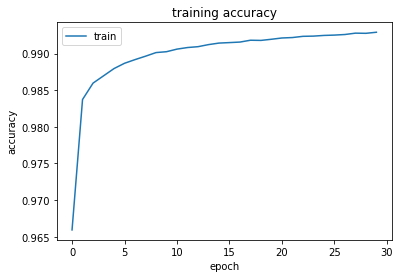

In [15]:
y_test_out = []
y_pred_out = []
for j in range(len(y_test_list)):
    print(len(y_test_list[j]), len(y_pred_list[j]), type(y_test_list[j]))
    y_test_out.extend(y_test_list[j])
    y_pred_out.extend(y_pred_list[j])

# plot accuracy over time
plt.figure()
history_acc = np.array([np.array(h.history['acc']) for h in history_list])
mean_history_acc = np.mean(history_acc, axis=0)

plt.plot(mean_history_acc, label='Keras (5cv_acc = {:.3f})'.format(np.mean(np.array(accuracy_list))))
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.savefig(figure_output_name+'.accuracy.png')

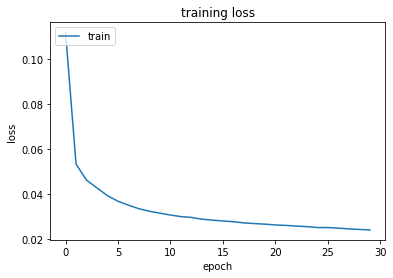

In [16]:
# plot loss over time
plt.figure()
history_loss = np.array([np.array(h.history['loss']) for h in history_list])
mean_history_loss = np.mean(history_loss, axis=0)

plt.plot(mean_history_loss)
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.savefig(figure_output_name+'.loss.png')

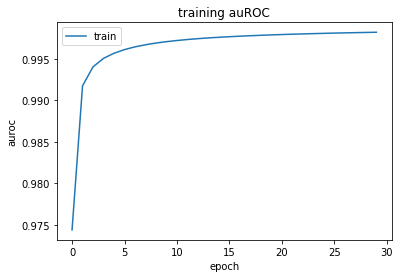

In [17]:
# auroc over time
plt.figure()
history_auroc = np.array([np.array(h.history['auroc']) for h in history_list])
mean_history_auroc = np.mean(history_auroc, axis=0)

plt.plot(mean_history_auroc)
plt.title('training auROC')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.savefig(figure_output_name+'.auROC.png')

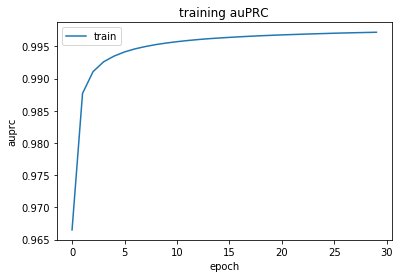

In [18]:
# auprc over time
plt.figure()
history_auprc = np.array([np.array(h.history['auprc']) for h in history_list])
mean_history_auprc = np.mean(history_auprc, axis=0)

plt.plot(mean_history_auprc)
plt.title('training auPRC')
plt.ylabel('auprc')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.savefig(figure_output_name+'.auPRC.png')

5 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


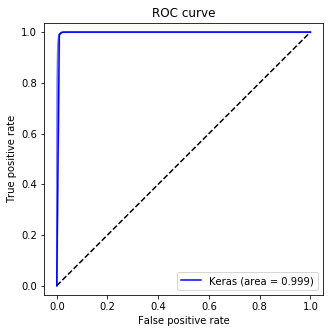

In [19]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(y_test_list)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_list[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(y_test_list[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)


print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

5 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


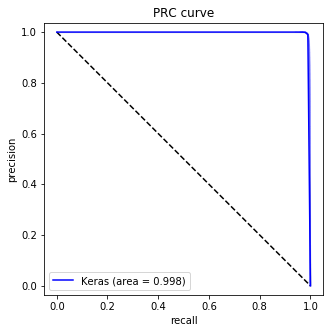

In [20]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(y_test_list)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(y_test_list[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(y_test_list[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [21]:
print("validation accuracy: " + str(np.mean(np.array(accuracy_list))))
print("validation auROC: " + str(np.mean(np.array(auroc_list))))
print("validation auPRC: " + str(np.mean(np.array(auprc_list))))

validation accuracy: 0.991128827324528
validation auROC: 0.9986728201963034
validation auPRC: 0.9981829870592478
